Part 1 - Q4 - CNN
===

I train and evaluate:

*  A Vanilla CNN model (once with one convulation stage, the other one with two convulation stages, but the two-stage one ovverwrites the one stage one. You can get it back by setting the parameter `with_second_layers_group` to `False` in the function `build_model(.)` ).
*  A one-stage CNN model with a residual block.
*  A two-stage CNN model with a residual block.

## Preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [2]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload

In [3]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

2024-05-21 22:07:31.528499: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 22:07:31.704006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 22:07:34.210986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
format_dict = par.create_format_dict()

In [5]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(False, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

### ML Preliminaries

In [6]:
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,MaxPooling1D, Add
from keras.optimizers import  SGD
from keras.optimizers import  RMSprop
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import sequence
from tensorflow.keras.layers import Bidirectional
from keras.losses import BinaryFocalCrossentropy
from keras.models import Model
from keras.layers import Input
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [8]:
import torch
import torch.nn.functional as F

In [9]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# Import Data

In [10]:
df_heart_test = pd.read_csv('../data_proj2/ptbdb_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/ptbdb_train.csv', header=None)

In [11]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Features preprocessing

In [12]:
x_train_0, x_test_0, y_train_0, y_test_0, lstm_input = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=True,
				with_lstm_transfo=True,
)

# Vanilla CNN - Two-stage Convolution

## Model Building

In [16]:
# Computing the alpha for focal loss
class_weights = y_train_0.value_counts() / len(y_train_0)
class_weights = 1-class_weights
alpha_focal_loss = class_weights.loc[1.0].values[0]

In [17]:
def build_model(
	n_filters=32,
	kernel_size=3,
	pool_size=2,
	learning_rate=0.001,
	lstm_dropout=0.7,
	recurrent_dropout = 0.7,
	final_dropout = 0.2,
	clipnorm=0.5,
	use_focal=False,
	use_bidirectional=False,
	use_sgd_opt=False,
	use_rms_opt=False,
	alpha_focal_loss=0.25,
	with_second_layers_group=False,
):
	if use_sgd_opt:
		opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
	elif use_rms_opt:
		opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
	else:
		opt = Adam(learning_rate=learning_rate)


	model = Sequential()
	model.add(Conv1D(
		filters=n_filters,
		kernel_size=kernel_size, strides=1, input_shape=(187,1), padding = 'same', activation = 'relu'
		))
	model.add(MaxPooling1D(pool_size=pool_size , strides = 1 , padding = 'same'))
	model.add(BatchNormalization())

	if with_second_layers_group:
		model.add(Conv1D(
			filters=n_filters*2,
			kernel_size=kernel_size, strides=1, padding = 'same', activation = 'relu'
			))
		model.add(MaxPooling1D(pool_size=pool_size , strides = 1 , padding = 'same'))
		model.add(BatchNormalization())	
	model.add(Dropout(final_dropout))
	model.add(Flatten())
	model.add(Dense(units = 1 , activation = 'sigmoid'))
	if use_focal:
		model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
	else:
		model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	print(model.summary())
	return model

In [18]:
model_cnn=build_model(
	n_filters=64,
	kernel_size=4,
	pool_size=2,
	learning_rate=0.02,
	use_focal=True,
	use_bidirectional=False,
	lstm_dropout=0.7,
	recurrent_dropout = 0.7,
	final_dropout = 0.7,
	clipnorm = 0.5,
	use_sgd_opt=False,
	use_rms_opt=True,
	with_second_layers_group=True,
	alpha_focal_loss=alpha_focal_loss,
    )

/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 64)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 187, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 187, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 187, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 187, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        23,937 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,921 (226.25 KB)

 Trainable params: 57,537 (224.75 KB)

 Non-trainable params: 384 (1.50 KB)

None


In [19]:
lib.custom_model_summary(model_cnn)

Model: "sequential"
Layer (type)                           Param #          Trainable
conv1d                              320                   True
max_pooling1d                       0                     True
batch_normalization                 256                   True
conv1d_1                            32896                 True
max_pooling1d_1                     0                     True
batch_normalization_1               512                   True
dropout                             0                     True
flatten                             0                     True
dense                               23937                 True
Total params: 57921
Trainable params: 57921
Non-trainable params: 0


## Training

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history = model_cnn.fit(
	lstm_input['x_train'],
	lstm_input['y_train'],
	epochs=20,
	batch_size=64*1,
	validation_data=(lstm_input['x_test'], lstm_input['y_test']),
	callbacks = [learning_rate_reduction],
	shuffle=False,
    )

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - accuracy: 0.6872 - loss: 23.7407 - val_accuracy: 0.3555 - val_loss: 0.5966 - learning_rate: 0.0200
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.6909 - loss: 1.3364 - val_accuracy: 0.7201 - val_loss: 1.7033 - learning_rate: 0.0200
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.6933 - loss: 1.0531 - val_accuracy: 0.3508 - val_loss: 2.7148 - learning_rate: 0.0200
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6957 - loss: 1.0736
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.005999999865889549.
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.6958 - loss: 1.0734 - val_accuracy: 0.7201 - val_loss: 1.4415 - learning_rate: 0.0200
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.7958 - loss: 0.2695 - val_accuracy: 0.7647 - val_loss: 0.1139 - learning_rate: 0.0060
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.785

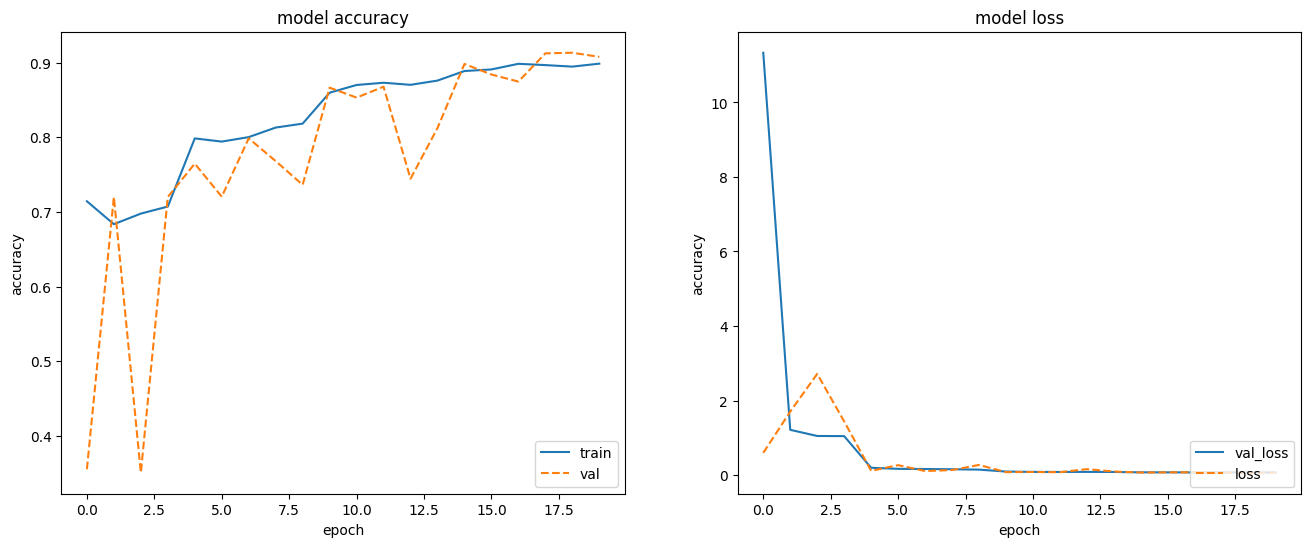

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

In [22]:
# # equivalent to: model.save("model.h5")
# from tensorflow.keras.models import save_model
# # save_model(model, "model_second_save.h5")
# # save model and architecture to single file
# model_cnn.save("cnn_simple.h5")
# model_cnn.save('cnn_simple.keras')
# print("Saved model to disk")


## Evaluation

In [23]:
_, _, _, _, lstm_input_eval = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=True,
)

In [24]:
y_pred = model_cnn.predict(lstm_input_eval['x_train'])
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred_df = pd.DataFrame(y_pred.round())
y_pred_df.value_counts()

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


0  
1.0    2182
0.0     729
Name: count, dtype: int64

In [25]:
y_pred_tensor, y_pred_round, y_pred_round_tensor = lib.process_for_eval_from_single_proba_array(y_pred)
y_true = torch.from_numpy(lstm_input_eval['y_train'])

In [26]:
summary_metrics = lib.compute_performance_metrics(y_true, y_pred_round)
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Class 0,F1 Class 1
metrics,90.8%,87.0%,82.6%,93.7%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

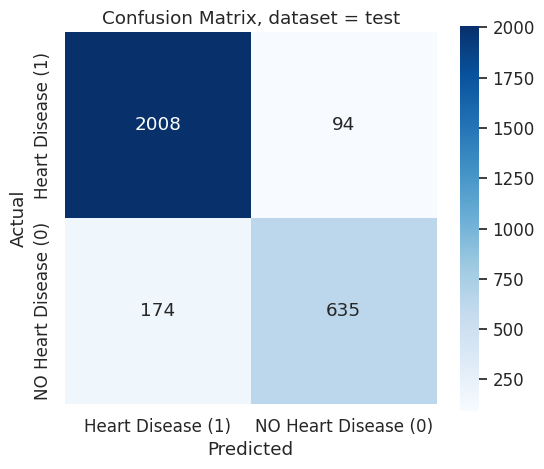

In [27]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [28]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:322: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


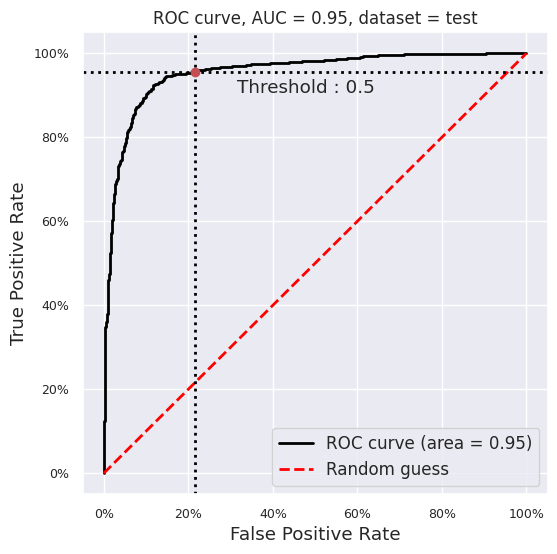

In [30]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

In [ ]:
# x_train_0, x_test_0, y_train_0, y_test_0, lstm_input = lib.pre_process_ecg(
#         df_heart_train,
#         label_col_pos=-1,
#         test_size=base.test_size,
#         random_state=base.random_state_test_train_split,
#         split_data=True,
# 				with_lstm_transfo=True,
# )

# Vanilla CNN - One-stage Convolution

## Model Building

In [31]:
# Computing the alpha for focal loss
class_weights = y_train_0.value_counts() / len(y_train_0)
class_weights = 1-class_weights
alpha_focal_loss = class_weights.loc[1.0].values[0]

In [33]:
model_cnn_one_stage=build_model(
	n_filters=64,
	kernel_size=4,
	pool_size=2,
	learning_rate=0.02,
	use_focal=True,
	use_bidirectional=False,
	lstm_dropout=0.7,
	recurrent_dropout = 0.7,
	final_dropout = 0.7,
	clipnorm = 0.5,
	use_sgd_opt=False,
	use_rms_opt=True,
	with_second_layers_group=False,
	alpha_focal_loss=alpha_focal_loss,
    )

/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 187, 64)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 187, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        11,969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 128 (512.00 B)

None


In [34]:
lib.custom_model_summary(model_cnn_one_stage)

Model: "sequential_1"
Layer (type)                           Param #          Trainable
conv1d_2                            320                   True
max_pooling1d_2                     0                     True
batch_normalization_2               256                   True
dropout_1                           0                     True
flatten_1                           0                     True
dense_1                             11969                 True
Total params: 12545
Trainable params: 12545
Non-trainable params: 0


## Training

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history = model_cnn_one_stage.fit(
	lstm_input['x_train'],
	lstm_input['y_train'],
	epochs=15,
	batch_size=64,
	validation_data=(lstm_input['x_test'], lstm_input['y_test']),
	callbacks = [learning_rate_reduction],
	shuffle=False,
    )

Epoch 1/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.6188 - loss: 3.6659 - val_accuracy: 0.7201 - val_loss: 0.7931 - learning_rate: 0.0200
Epoch 2/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6506 - loss: 0.4559 - val_accuracy: 0.7201 - val_loss: 0.8676 - learning_rate: 0.0200
Epoch 3/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6696 - loss: 0.4976 - val_accuracy: 0.7888 - val_loss: 0.1129 - learning_rate: 0.0200
Epoch 4/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6852 - loss: 0.4658 - val_accuracy: 0.7943 - val_loss: 0.1105 - learning_rate: 0.0200
Epoch 5/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.6804 - loss: 0.4685 - val_accuracy: 0.7201 - val_loss: 0.6315 - learning_rate: 0.0200
Epoch 6/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6995 - loss: 0.4635
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.005999999865889549.
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.6994 - loss: 0.4

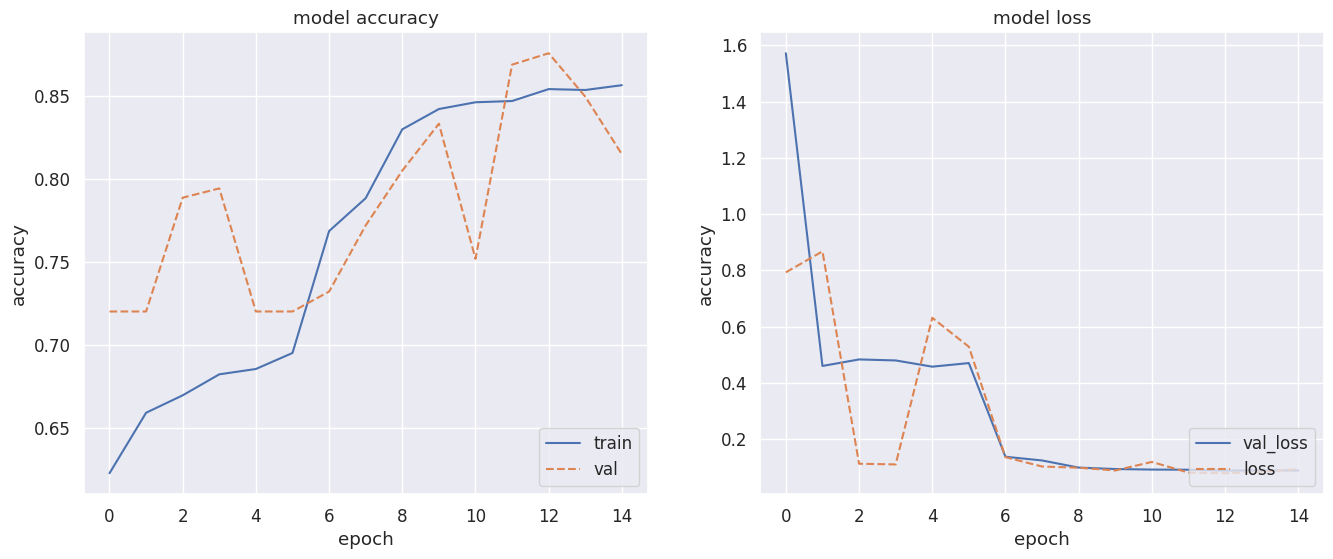

In [36]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

In [37]:
# # equivalent to: model.save("model.h5")
# from tensorflow.keras.models import save_model
# # save_model(model, "model_second_save.h5")
# # save model and architecture to single file
# model_cnn.save("cnn_simple.h5")
# model_cnn.save('cnn_simple.keras')
# print("Saved model to disk")


## Evaluation

In [38]:
_, _, _, _, lstm_input_eval = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=True,
)

In [39]:
y_pred = model_cnn_one_stage.predict(lstm_input_eval['x_train'])
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred_df = pd.DataFrame(y_pred.round())
y_pred_df.value_counts()

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


0  
1.0    2607
0.0     304
Name: count, dtype: int64

In [40]:
y_pred_tensor, y_pred_round, y_pred_round_tensor = lib.process_for_eval_from_single_proba_array(y_pred)
y_true = torch.from_numpy(lstm_input_eval['y_train'])

In [41]:
summary_metrics = lib.compute_performance_metrics(y_true, y_pred_round)
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Class 0,F1 Class 1
metrics,80.9%,66.6%,50.1%,88.2%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

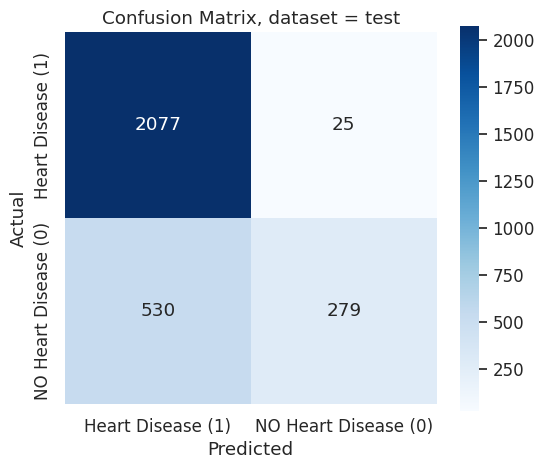

In [42]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [43]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

In [44]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:322: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


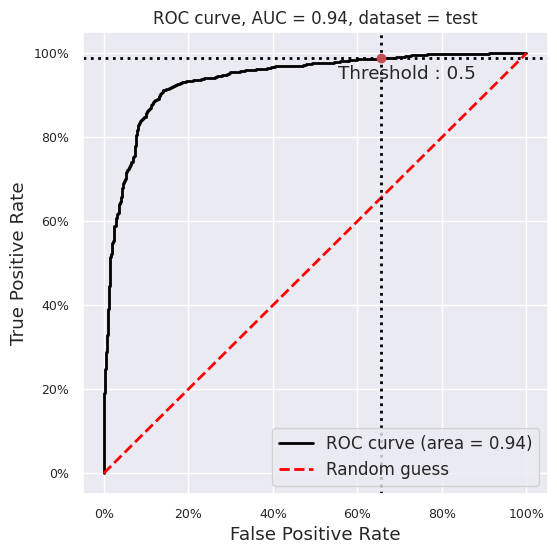

In [45]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

# Residual Blocks + CNN

## Model Building

In [46]:
# Computing the alpha for focal loss
class_weights = y_train_0.value_counts() / len(y_train_0)
class_weights = 1-class_weights
alpha_focal_loss = class_weights.loc[1.0].values[0]

In [48]:
def cnn_with_residual_blocks(
	input_shape = (187,1),
	n_filters=32,
	kernel_size=3,
	pool_size=2,
	learning_rate=0.001,
	final_dropout = 0.2,
	with_second_layers_group=False,
	):
	# Define the input as a tensor with shape input_shape
	input = Input(input_shape)

	# Stage 1
	fx = Conv1D(filters=n_filters, kernel_size=kernel_size, strides=1, padding = 'same', activation = 'relu')(input)
	fx = MaxPooling1D(pool_size=pool_size , strides = 1 , padding = 'same')(fx)
	fx = BatchNormalization()(fx)

	# Stage 2
	if with_second_layers_group:
		fx = Conv1D(filters=n_filters, kernel_size=kernel_size, strides=1, padding = 'same', activation = 'relu')(fx)
		fx = MaxPooling1D(pool_size=pool_size , strides = 1 , padding = 'same')(fx)
		fx = BatchNormalization()(fx)

	# Combining the two blocks
	out = Add()([input,fx])

	# Output layer
	out = Dropout(final_dropout)(out)
	out = Flatten()(out)
	out = Dense(units = 1 , activation = 'sigmoid')(out)

	# Create model
	model = Model(inputs = input, outputs = out, name='ResNet50')
	return model

In [49]:
def compile_cnn_with_residual_blocks(
	n_filters=64,
	kernel_size=4,
	pool_size=2,
	learning_rate=0.02,
	use_focal=True,
	use_bidirectional=False,
	lstm_dropout=0.7,
	recurrent_dropout = 0.7,
	final_dropout = 0.7,
	clipnorm = 0.5,
	use_sgd_opt=False,
	use_rms_opt=True,
	with_second_layers_group=True,
	alpha_focal_loss=alpha_focal_loss,
):

	model_resnet = cnn_with_residual_blocks(
		n_filters=n_filters,
		kernel_size=kernel_size,
		pool_size=pool_size,
		final_dropout=final_dropout,
		with_second_layers_group=with_second_layers_group,
	)

	if use_sgd_opt:
		opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
	elif use_rms_opt:
		opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
	else:
		opt = Adam(learning_rate=learning_rate)

	model_resnet.summary()
	if use_focal:
		model_resnet.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
	else:
		model_resnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model_resnet

In [50]:
model_resnet=compile_cnn_with_residual_blocks(
	n_filters=64,
	kernel_size=4,
	pool_size=2,
	learning_rate=0.02,
	use_focal=True,
	final_dropout = 0.7,
	clipnorm = 0.5,
	use_sgd_opt=False,
	use_rms_opt=True,
	with_second_layers_group=False,
	alpha_focal_loss=alpha_focal_loss,
	)

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 187, 64)   │        320 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 187, 64)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ max_pooling1d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 187, 64)   │          0 │ input_layer_2[0]… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 187, 64)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 11968)     │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │     11,969 │ flatten_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 128 (512.00 B)

In [51]:
lib.custom_model_summary(model_resnet)

Model: "ResNet50"
Layer (type)                           Param #          Trainable
input_layer_2                       0                     True
conv1d_3                            320                   True
max_pooling1d_3                     0                     True
batch_normalization_3               256                   True
add                                 0                     True
dropout_2                           0                     True
flatten_2                           0                     True
dense_2                             11969                 True
Total params: 12545
Trainable params: 12545
Non-trainable params: 0


## Training

In [52]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history = model_resnet.fit(
	lstm_input['x_train'],
	lstm_input['y_train'],
	epochs=20,
	batch_size=64*1,
	validation_data=(lstm_input['x_test'], lstm_input['y_test']),
	callbacks = [learning_rate_reduction],
	shuffle=False,
    )



Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.6764 - loss: 5.5819 - val_accuracy: 0.7497 - val_loss: 2.6685 - learning_rate: 0.0200
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7168 - loss: 2.5004 - val_accuracy: 0.7918 - val_loss: 1.1865 - learning_rate: 0.0200
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7251 - loss: 2.6218 - val_accuracy: 0.7892 - val_loss: 1.6459 - learning_rate: 0.0200
Epoch 4/20
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7395 - loss: 2.5588
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.005999999865889549.
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7396 - loss: 2.5583 - val_accuracy: 0.7201 - val_loss: 11.2868 - learning_rate: 0.0200
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7970 - loss: 1.5234 - val_accuracy: 0.4100 - val_loss: 10.0056 - learning_rate: 0.0060
Epoch 6/20
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8096 - loss: 1

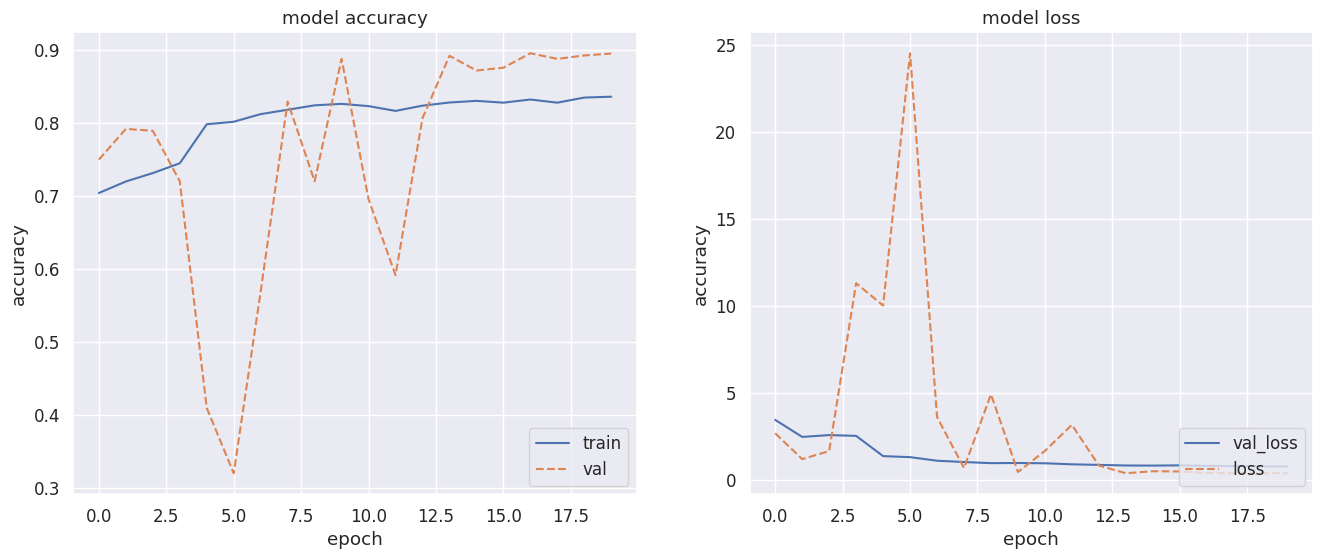

In [59]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

In [60]:
# equivalent to: model.save("model.h5")
# save_model(model, "model_second_save.h5")
# save model and architecture to single file
model_resnet.save("model_resnet.h5")
model_resnet.save('model_resnet.keras')
print("Saved model to disk")


Saved model to disk


## Evaluation

In [61]:
_, _, _, _, lstm_input_eval = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=True,
)

In [62]:
y_pred = model_resnet.predict(lstm_input_eval['x_train'])
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred_df = pd.DataFrame(y_pred.round())
y_pred_df.value_counts()

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


0  
1.0    2091
0.0     820
Name: count, dtype: int64

In [63]:
y_pred_tensor, y_pred_round, y_pred_round_tensor = lib.process_for_eval_from_single_proba_array(y_pred)
y_true = torch.from_numpy(lstm_input_eval['y_train'])

In [64]:
summary_metrics = lib.compute_performance_metrics(y_true, y_pred_round)
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Class 0,F1 Class 1
metrics,89.1%,86.6%,80.5%,92.4%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

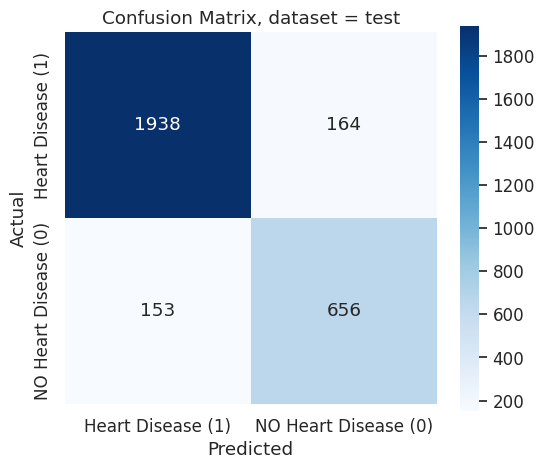

In [66]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [67]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:322: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


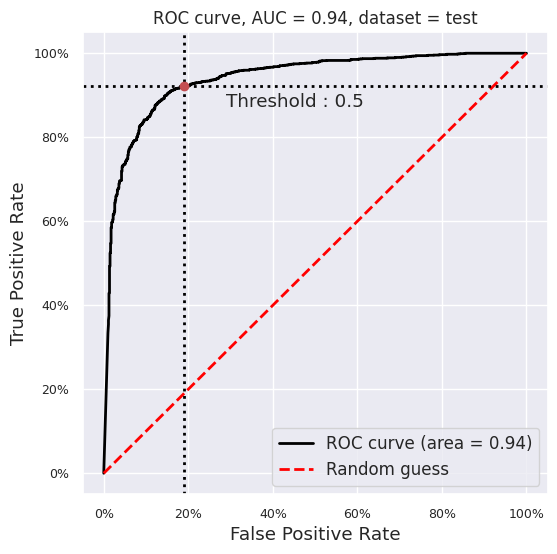

In [69]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

# Residual Blocks + CNN: complex CNN (2 stages)

## Model Building

Note that the functions are defined in the previous section and that here we are only instantiating anoter resnet model, but this time with 2 stages of convolution instead of one.

In [70]:
model_resnet_2_stages=compile_cnn_with_residual_blocks(
	n_filters=64,
	kernel_size=4,
	pool_size=2,
	learning_rate=0.02,
	use_focal=True,
	final_dropout = 0.7,
	clipnorm = 0.5,
	use_sgd_opt=False,
	use_rms_opt=True,
	with_second_layers_group=True,
	alpha_focal_loss=alpha_focal_loss,
	)

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 187, 64)   │        320 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 187, 64)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ max_pooling1d_4[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 187, 64)   │     16,448 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 187, 64)   │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ max_pooling1d_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 187, 64)   │          0 │ input_layer_3[0]… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 187, 64)   │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 11968)     │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │     11,969 │ flatten_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,249 (114.25 KB)

 Trainable params: 28,993 (113.25 KB)

 Non-trainable params: 256 (1.00 KB)

In [71]:
lib.custom_model_summary(model_resnet_2_stages)

Model: "ResNet50"
Layer (type)                           Param #          Trainable
input_layer_3                       0                     True
conv1d_4                            320                   True
max_pooling1d_4                     0                     True
batch_normalization_4               256                   True
conv1d_5                            16448                 True
max_pooling1d_5                     0                     True
batch_normalization_5               256                   True
add_1                               0                     True
dropout_3                           0                     True
flatten_3                           0                     True
dense_3                             11969                 True
Total params: 29249
Trainable params: 29249
Non-trainable params: 0


## Training

In [314]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history = model_resnet_2_stages.fit(
	lstm_input['x_train'],
	lstm_input['y_train'],
	epochs=20,
	batch_size=64*1,
	validation_data=(lstm_input['x_test'], lstm_input['y_test']),
	callbacks = [learning_rate_reduction],
	shuffle=False,
    )



Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.6749 - loss: 11.7107 - val_accuracy: 0.7201 - val_loss: 12.8101 - learning_rate: 0.0200
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.7493 - loss: 1.9899 - val_accuracy: 0.7093 - val_loss: 1.8670 - learning_rate: 0.0200
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7729 - loss: 1.8131
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.005999999865889549.
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7729 - loss: 1.8128 - val_accuracy: 0.7196 - val_loss: 5.7323 - learning_rate: 0.0200
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8308 - loss: 1.0710 - val_accuracy: 0.7793 - val_loss: 1.2927 - learning_rate: 0.0060
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8451 - loss: 0.7396 - val_accuracy: 0.8089 - val_loss: 0.8423 - learning_rate: 0.0060
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.8505 - lo

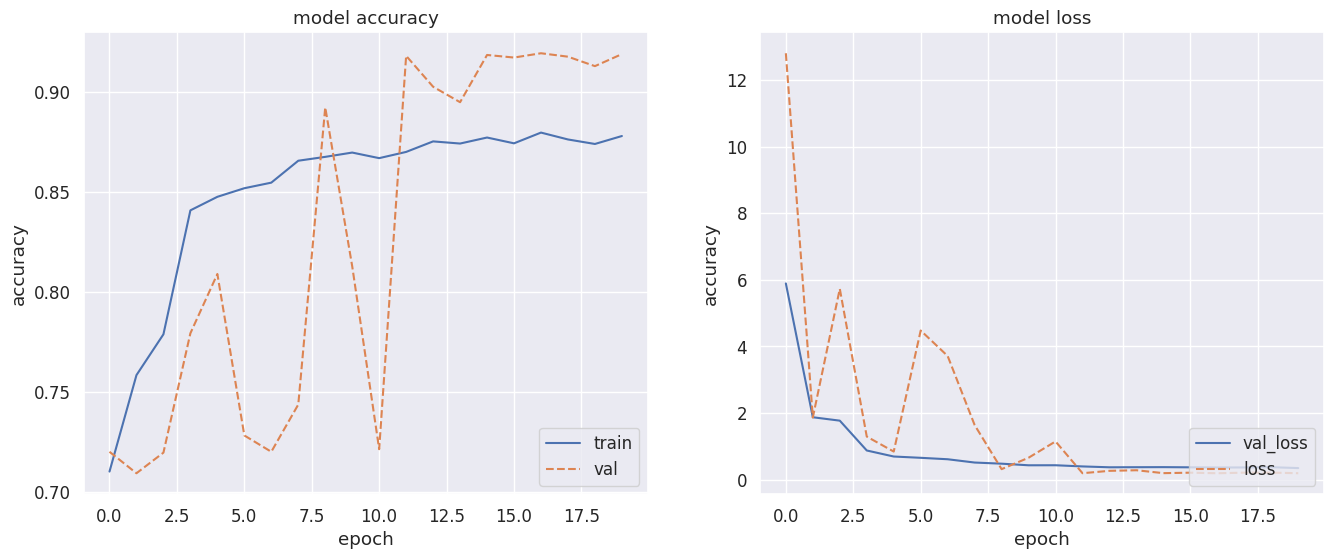

In [316]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

In [326]:
# # equivalent to: model.save("model.h5")
# model_resnet_2_stages.save("model_resnet_2_stages.h5")
# model_resnet_2_stages.save('model_resnet_2_stages.keras')
# print("Saved model to disk")

Saved model to disk


## Evaluation

In [73]:
# from tensorflow.keras.models import load_model

# # Load the pre-trained encoder
# model_resnet_2_stages = load_model('model_resnet_2_stages.keras')

In [74]:
_, _, _, _, lstm_input_eval = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=True,
)

In [75]:
y_pred = model_resnet_2_stages.predict(lstm_input_eval['x_train'])
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred_df = pd.DataFrame(y_pred.round())
y_pred_df.value_counts()

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


0  
1.0    2124
0.0     787
Name: count, dtype: int64

In [76]:
y_pred_tensor, y_pred_round, y_pred_round_tensor = lib.process_for_eval_from_single_proba_array(y_pred)
y_true = torch.from_numpy(lstm_input_eval['y_train'])

In [77]:
summary_metrics = lib.compute_performance_metrics(y_true, y_pred_round)
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Class 0,F1 Class 1
metrics,92.0%,89.7%,85.5%,94.5%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

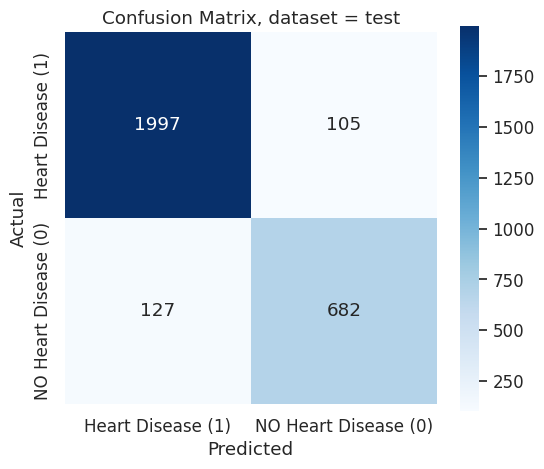

In [78]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [79]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:322: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


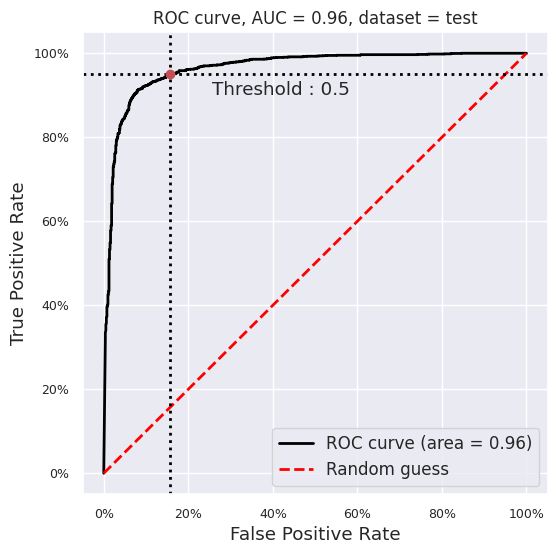

In [80]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)